In [1]:
# Incase we have to clear all variables
%reset -f

In [2]:

from dimer_setup import *

# Convergence data calculations

In [3]:
def calculate_steadystate(H, L, fill_factor=47):
    calculated = False
    ff = fill_factor
    tol = 1e-9
    ss = 0
    while not calculated:
        try:
            ss = steadystate(H[1], [L], method='iterative-gmres',
                                   use_precond=True, fill_factor=fill_factor,
                                   drop_tol=1e-3, use_rcm=True, return_info=True,
                                   tol=tol, maxiter=20000)
            calculated=True
            return ss[0], ss[1]
        except Exception as err:
            print "Steadystate failed because {}.".format(err, fill_factor)
            return 0,0
    


def heat_map_calculator(PARAMS,
                        x_axis_parameters=['w0_1', 'w0_2'],
                        y_axis_parameters=['Gamma_1', 'Gamma_2'],
                        x_values=[100., 200., 300.],
                        y_values=[70., 200., 600.],
                        dir_name='heatmap_oG', fill_factor=47):
    info_array = np.zeros(( len(y_values), len(x_values)), dtype=dict)
    ss_array = np.zeros(( len(y_values), len(x_values)), dtype=qt.Qobj)
    for i, y in enumerate(y_values):
        for param_labels in y_axis_parameters:
            PARAMS.update({param_labels : y})
        for j, x in enumerate(x_values):
            # scan over each combination of parameters and update the PARAMS dict
            # for each point on the grid
            for param_labels in x_axis_parameters:
                PARAMS.update({param_labels : x})
            if 'exc' in x_axis_parameters:
                PARAMS.update({'exc': PARAMS['N_1']+PARAMS['exc_diff']})
            if 'exc_diff' in y_axis_parameters:
                PARAMS.update({'exc' : PARAMS['N_1']+PARAMS['exc_diff']})
            ti = time.time()
            silent = True
            if PARAMS['N_1'] >=8:
                silent = False
            H, L = get_H_and_L(PARAMS,silent=silent)
            tf = time.time()
            ss, info = calculate_steadystate(H, L, fill_factor=fill_factor)
            del H, L
            ss_array[i][j], info_array[i][j] = ss, info
            try:
                ts = info['solution_time']
                print "N_1 = {}, N_2 = {}, exc= {}".format(PARAMS['N_1'], PARAMS['N_2'], PARAMS['exc'])
                print "Build time: {:0.3f} \t | \t Solution time: {:0.3f}".format(tf-ti, 
                                                                                  ts)
            except TypeError:
                print "N_1 = {}, N_2 = {}, exc= {} - Calculation skipped...".format(PARAMS['N_1'], 
                                                                                      PARAMS['N_2'], 
                                                                                      PARAMS['exc'])
                

    # Pass variables through so heatmap_plotter knows what to do
    PARAMS.update({'x_axis_parameters': x_axis_parameters, 
                             'y_axis_parameters': y_axis_parameters,
                          'x_values': x_values, 'y_values': y_values})
    
    k = 1
    saved = False
    while not saved:
        directory = 'DATA/'+dir_name+'_'+str(k)
        if not os.path.exists(directory):
            os.makedirs(directory)
            save_obj(ss_array, directory+'/ss_array')
            save_obj(PARAMS, directory+'/PARAMS')
            save_obj(info_array, directory+'/info_array')
            saved = True
            print "Files saved at {}".format(directory)
        else:
            k+=1
    return ss_array, info_array


# Running the convergence tests

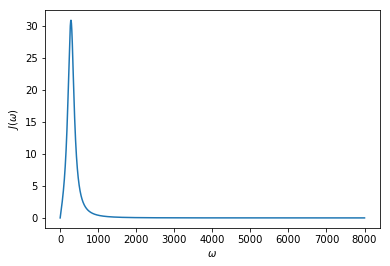

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 283.528352835. N=7.


In [ ]:
# T_ph vs N
w_2 = 8000.
alpha = 20.
x_values=[2,3]
x_values=[2,3,4,5,6,7,8][::-1]
pap = alpha_to_pialpha_prop(alpha, w_2)
pars = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=0.1, shift=True,
                                 num_cpus=3, N=x_values[0], Gamma=200., w_0=300.,
                                 silent=False)
exc = pars['exc']

 # N
y_values=[4,3,2,1,0] # T_ph
try:

    ss_array, info_array= heat_map_calculator(pars,
                            x_axis_parameters=['N_1', 'N_2'],
                            y_axis_parameters=['exc_diff'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name='heatmap_excvN', 
                            fill_factor=500)
except Exception as err:
    print "Error: This means that an error has been raised internally in the SS calculator. Message {}".format(err)

# Plotting methods

In [8]:
def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = N+PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': N+y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    print ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array


def heatmap_plotter(num, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    info = info_array[0][0]
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    
    ss_array = steadystate_observable(ss_array, PARAMS, observable)

    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        if reverse_x:
            x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    
    print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

new style
(120, 120) (120, 120)
(104, 104) (104, 104)
(96, 96) (96, 96)
(88, 88) (88, 88)
(76, 76) (76, 76)
(64, 64) (64, 64)
(60, 60) (60, 60)
(52, 52) (52, 52)
(36, 36) (36, 36)
(36, 36) (36, 36)
(32, 32) (32, 32)
(16, 16) (16, 16)
(16, 16) (16, 16)
(16, 16) (16, 16)
kappa_2=97.08, kappa_1=97.08, T_EM=6000.00, bias=100.00, alpha_2=20.00, alpha_1=20.00, T_2=300.00, T_1=300.00, Gamma_1=200.00, Gamma_2=200.00, mu=0.99, w_1=8100.00, w0_1=300.00, w0_2=300.00, V=100.00, w_2=8000.00, dipole_2=1.00, dipole_1=1.00, exc=2.00, alpha_EM=0.10, shift2=31.42, shift1=31.42, w_xx=16100.00, gamma_1=0.11, gamma_2=0.11
saved at PLOTS/heatmap_excvN_1.pdf


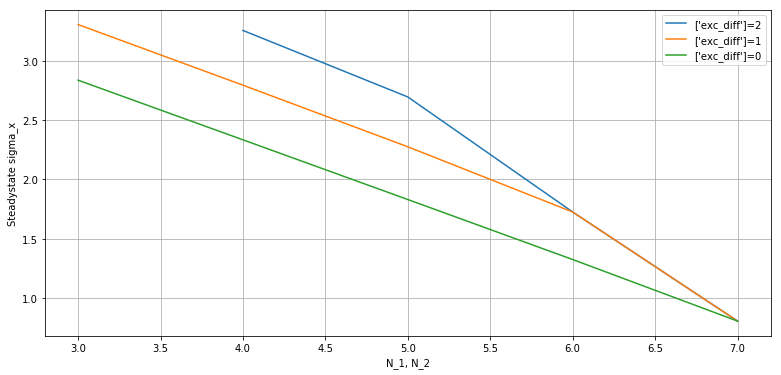

In [9]:
heatmap_plotter(1, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True)